# Importing libraries

In [120]:
# importing libraries
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import scipy.stats as stats

In [121]:
### Initial definitions and loading of datasets

# dataset file paths
data_path = './data/yt_metadata_en.jsonl.gz'
channels_path = './data/df_channels_en.tsv'
timeseries_path = './data/df_timeseries.tsv'

# Define the start and end dates of our study
start_date = pd.Timestamp('2016-01-01')
end_date = pd.Timestamp('2019-12-31')

### loading datasets
df_channels = pd.read_csv(channels_path, sep ='\t')
df_timeseries = pd.read_csv(timeseries_path, sep ='\t')
# youtube metadata is not loaded at this point because of its large size. 
# We will proceed to pre-process and load it under the preprocessing section. 

# convert dates into datetime format
df_channels['join_date'] = pd.to_datetime(df_channels['join_date'])
df_timeseries['datetime'] = pd.to_datetime(df_timeseries['datetime'])

# only keep data within the dates of interest for our study
df_channels.drop(df_channels[df_channels.join_date > end_date].index, inplace=True)
df_timeseries.drop(df_timeseries[df_timeseries.datetime > end_date].index, inplace=True)
df_timeseries.drop(df_timeseries[df_timeseries.datetime < start_date].index, inplace=True)

display(df_timeseries)
display(df_channels)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,2.024946e+05,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,3.940857e+05,191591.111111,1046.000000,395.777778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17,8.353938e+05,441308.083333,1501.500000,455.500000,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24,1.104577e+06,269183.250000,1750.000000,248.500000,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31,1.284406e+06,179828.600000,2008.300000,258.300000,6,0,0
...,...,...,...,...,...,...,...,...,...,...
21553643,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-02,6.012938e+06,232418.277778,61268.611111,1305.611111,278,2,10
21553644,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-09,6.244579e+06,231640.888889,62631.666667,1363.055556,287,9,13
21553645,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-16,6.480902e+06,236322.933333,64010.000000,1378.333333,294,7,16
21553646,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-23,6.745317e+06,264415.200000,65480.000000,1470.000000,301,7,15


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.0870
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.0870
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.0870
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.0870
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.0870
...,...,...,...,...,...,...,...,...
136465,Music,2016-10-06,UCuM-9AajUOwKw6ipOzu2DRQ,GONE.Fludd - Topic,10128,105,1008139.0,53.1435
136466,People & Blogs,2013-10-17,UCtW9jp5TH0YrgYpwiRf9t-Q,saidthestory,10100,352,1008644.0,53.1435
136467,Gaming,2015-05-08,UCTsxFTIUs8vFDzGccDm6i7Q,Omni H,10000,475,1009505.0,53.1435
136468,Music,2011-04-13,UC1HOArgRCMGPjlcmkThERwA,TĀLĀ,10000,15,1025119.0,53.1435


# First look at the data

In this section, we will plot some graphs to get a preliminary understanding of the data we will be working with. 

## Data on YouTube Channels

We will first make a plot of channels by categories, for each of the three years along the x-axis, and the y, is the channel count. This will give us an idea of the categories with the most number channel created in each year. 

We will restrict our data of interest to those between the years of 2016 and 2019 since those are the years of interest for our study. 

We will then make a plot over the distributions of subscriber count (subscriber_cc). 

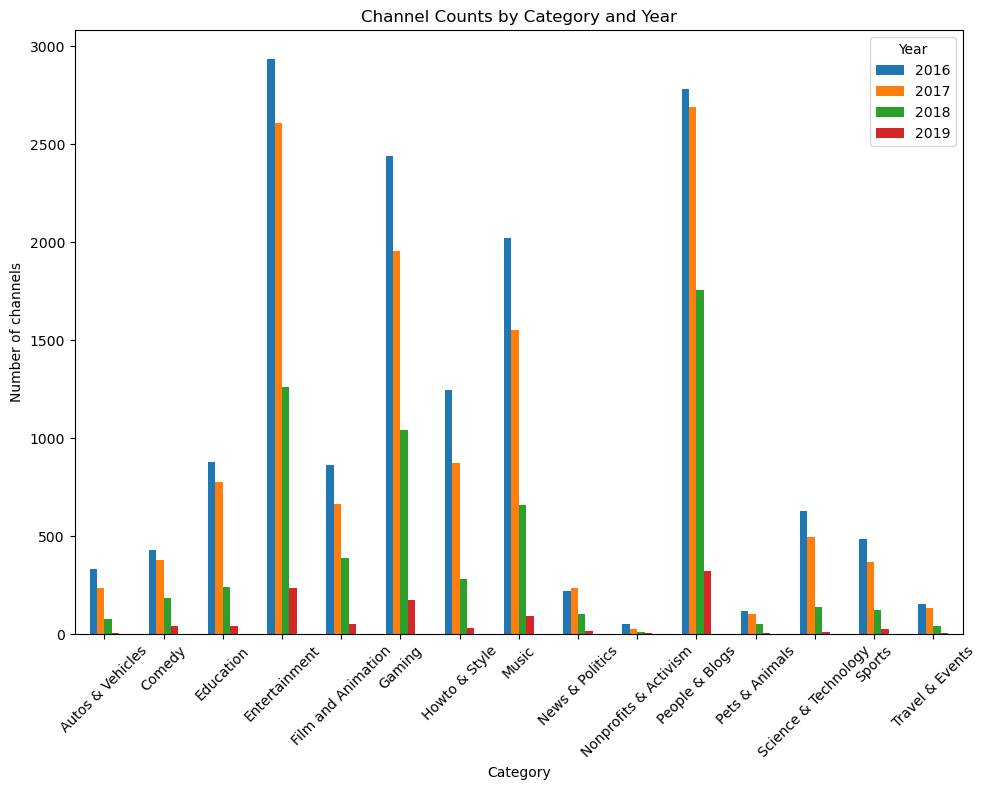

In [122]:
# Filter out channels created before 2016, since 
channels_graph = df_channels.drop(df_channels[df_channels.join_date < start_date].index)

# First, we'll add a 'year' column to our DataFrame for grouping our data later
channels_graph['year'] = channels_graph['join_date'].dt.year

# Now, group by 'category_cc' and 'year' and count the number of occurrences
category_counts = channels_graph.groupby(['category_cc', 'year']).size().unstack(level=1)

# Plot number of channels joining each year
category_counts.plot(kind='bar', figsize=(10, 8))
plt.title('Channel Counts by Category and Year')
plt.xlabel('Category')
plt.ylabel('Number of channels')
plt.xticks(rotation=45)  # Rotate category labels if they overlap
plt.legend(title='Year', labels = [2016, 2017, 2018, 2019])
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

### Identifying missing data in channels dataset
Since the `df_channels_en.tsv` dataset is known to be obtained in September of 2019, there is likely to be missing channel data in the year 2019. In this section, we will proceed to acertain the date from which we no longer have channel data. 

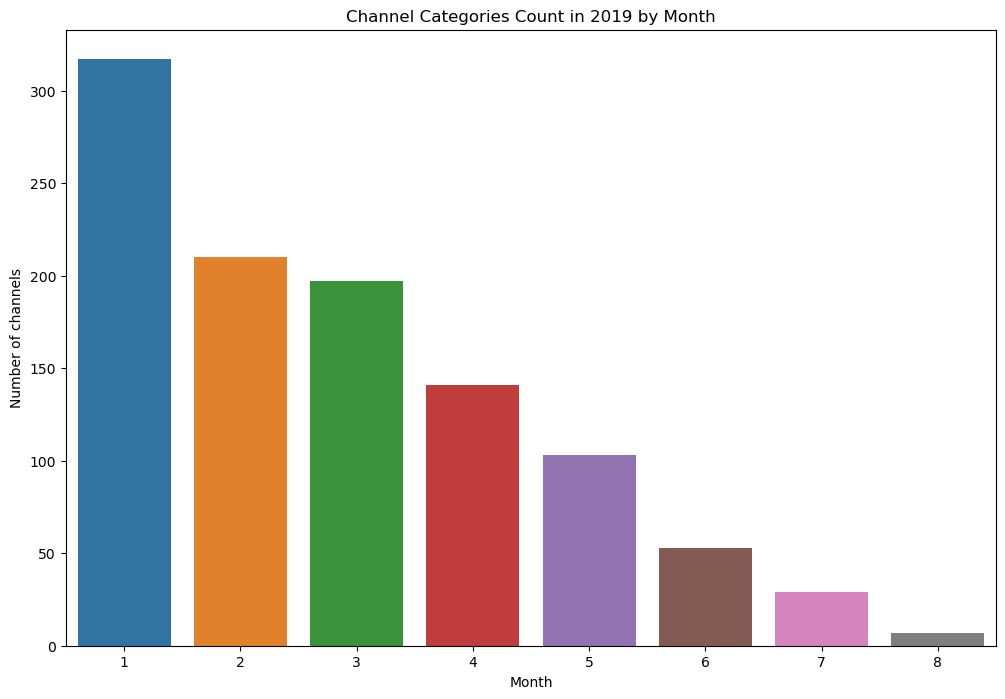

'Last channel join date in the dataset: 2019-08-23 00:00:00'

In [123]:
# Plotting the number of channels joining in 2019 by month to identify missing data

channels_2019 = channels_graph[(channels_graph['join_date']>='2019-01-01') & (channels_graph['join_date']<='2019-12-31')].copy()
channels_2019['month'] = channels_2019['join_date'].dt.month

# Group by 'month' and then get the size of each grouping
category_counts_2019 = channels_2019.groupby(['month']).size().reset_index(name='counts')

# Now, plot the results with seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='month', y='counts', data=category_counts_2019)

plt.title('Channel Categories Count in 2019 by Month')
plt.xlabel('Month')
plt.ylabel('Number of channels')
plt.show()

# find the channel with the last join date in the channels dataset
display("Last channel join date in the dataset: " + str(channels_2019['join_date'].max()))

## YouTube Timeseries data

We have identified the categories of **Gaming**, **People & Blogs** and **How-to & Style** as categories of interest for our project. In this section, we will proceeed to take a closer look at the timeseries data for these categories of videos. We will first look at the number of videos in each category in each year to get a preliminary understanding of the size of the data we will be working with. 

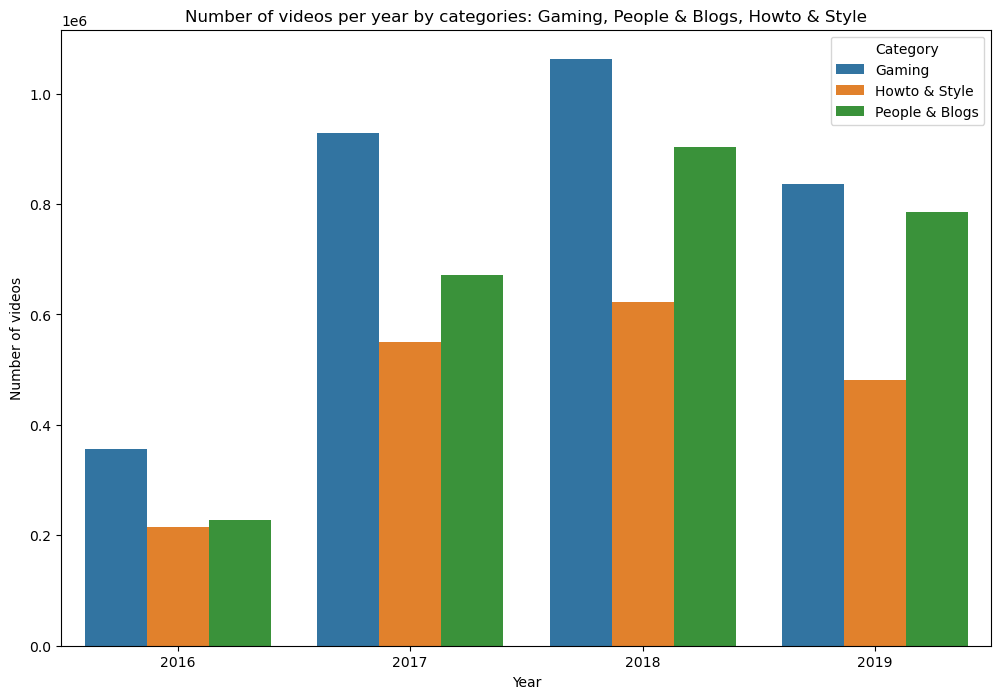

In [124]:
# Filter timeseries data to only include videos in categories of interest
video_cat_timeseries = df_timeseries[df_timeseries['category'].isin(['Gaming', 'People & Blogs', 'Howto & Style'])].copy()

# Extract the year from channel join date into a new column
video_cat_timeseries['year'] = video_cat_timeseries['datetime'].dt.year

# get size of each year and channel category group
video_category_counts = video_cat_timeseries.groupby(['year', 'category']).size().reset_index(name='counts')

# Now, plot the a graph of number of videos according to category and year
plt.figure(figsize=(12, 8))
sns.barplot(x='year', y='counts', hue='category', data=video_category_counts)
plt.title('Number of videos per year by categories: Gaming, People & Blogs, Howto & Style')
plt.xlabel('Year')
plt.ylabel('Number of videos')
plt.legend(title='Category')
plt.show()

### Identifying missing timeseries data

In this section, we will conduct a sanity check on the timeseries data for any potential missing data in the time period of 2016-2019 that we are interested in for our study. 

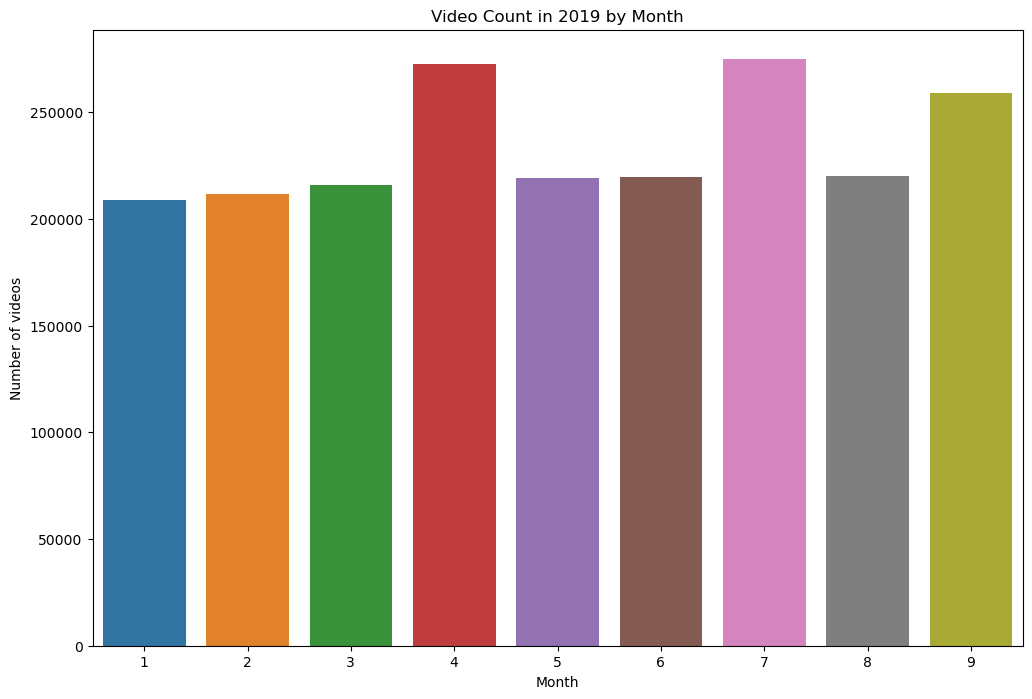

'Last video posted on the date: 2019-09-30 01:00:00'

In [125]:
# Plotting the number of videos created in 2019 by month to identify missing data

videos_2019 = video_cat_timeseries[(video_cat_timeseries['datetime']>='2019-01-01') & (video_cat_timeseries['datetime']<='2019-12-31')].copy()
videos_2019['month'] = videos_2019['datetime'].dt.month

# Group by 'month' and then get the size of each grouping
video_counts_2019 = videos_2019.groupby(['month']).size().reset_index(name='counts')

# Now, plot the results with seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='month', y='counts', data=video_counts_2019)

plt.title('Video Count in 2019 by Month')
plt.xlabel('Month')
plt.ylabel('Number of videos')
plt.show()

# find the channel with the last join date in the channels dataset
display("Last video posted on the date: " + str(videos_2019['datetime'].max()))

#### Comment on missing data in channels and timeseries dataset

The last available channel in the channel dataset joined on 23rd August 2019 and the last available video was posted on 30th September 2019. There is roughly a 1.5 month difference between the date of last joined channel and the date of last video posted available in our dataset. We will keep in mind that there are missing data from 23rd August 2019 onwards in the `df_channels_en.tsv` dataset and missing data from 30th September 2019 onwards in the `df_timeseries.tsv` dataset. 

# Preprocessing data

## Relevant datasets
The datasets that we will work with for our project are: 
- `yt_metadata_en.jsonl.gz`
- `df_channels_en.tsv.gz`
- `df_timeseries_en.csv.gz`

## Reading Youtube video metadata 
As we are primarily interested in the collaborations between youtube channels, we will process the data within the `yt_metadata_en.jsonl.gz` dataset to identify collaborations between youtube channels. As the metadate set is very large, we will first define some function which will help us filter the dataset as we read it in. 

The main purpose of the `yt_metadata_en.jsonl.gz` dataset in our project is to provide collaboration information between youtube channels. 

Thus, we will use the dataset to find collaborators IDs in the description of each video. Afterwhich, we will drop the `description`, `title`, and `tags` columns of the dataset as these are not relevant to our study. 

In [126]:
## Preparing channels dataframe for future use in mapping channel name to channel ID

# keeping only the channel_id and channel_name
channel_ids_and_names = df_channels[['channel' , 'name_cc']].copy()
# rename channel id and channel name for readability
channel_ids_and_names.rename(columns={"channel": "channel_id", "name_cc": "channel_name"} , inplace= True)

# convert to unique ids to set for better efficiency
unique_ids_set = set(channel_ids_and_names.channel_id.unique())
# create a dictionary of channel name to id for faster lookup
channel_name_to_id = pd.Series(channel_ids_and_names.channel_id.values, index=channel_ids_and_names.channel_name.str.lower()).to_dict()

### Extracting collaborating channels from video descriptions

With the filtered dataframes, we can search for indications of collaboration between youtube channels by identifying channel links in the video descriptions. 

According to the [official youtube website](https://support.google.com/youtube/answer/6180214?hl=en), youtube channel urls can take the following 4 forms: 
1. Channel url: youtube.com/channel/unique_channel_id
2. Handle url: youtube.com/@youtube_channel
3. Custom url: youtube.com/c/youtube_channel
4. Legacy username url: youtube.com/user/youtube_channel_username

Thus, we will search video descriptions for links with any format from above. Formats 1 and 4 contains the channel ID as part of the link while formats 2 and 3 contain channel names. 

Channel names found will be appended to a new column, `channe_name`, while channel IDs found will be appended to another column, `channel_id`, in the dataframe. If more than one channel is mentioned, all channels will be appeneded in a list. 


In [127]:
### Identifying channel collaboration: scraping youtube channel links from the description

# function to extract all youtube channel IDs and channel names (4.4 seconds to run)
def extract_youtube_channels(text):
    
    # regex for finding YouTube channel URLs
    channel_id_pattern = r'https?://www\.youtube\.com/(?:channel/|user/)([\w-]+)'
    channel_name_pattern = r'https?://www\.youtube\.com/(?:@|c/)([\w-]+)'

    # find all links that match the patterns
    channel_ids = re.findall(channel_id_pattern, text)
    channel_names = re.findall(channel_name_pattern, text)

    # # join the IDs and names found (or None if not found)
    channel_id = channel_ids if channel_ids else None
    channel_name = channel_names if channel_names else None

    return channel_id, channel_name

## Constructing Video Collaboration dataset

From the dataset containing the channel IDs/names of channels mentioned in each video's description, we will construct a dataset that contains videos with channel collaboration (represented by the channel id of the collaborating channel). 

To do so, we need the new dataset to satisfy 2 conditions
1. Channel ID/name listed as the collaborating channel must be different from channel ID/name of video creator. (A channel cannot collaborate with itself)
2. Channel ID should not be empty 

Channel names identified in the description in column `'mentioned_channel_name'` (without corresponding channel ids) will be matched to its corresponding channel ID in the `channel_ids_and_names` dataset (constructed from the given `df_channels_en.tsv.gz` dataset). 

We chose to keep channel IDs as the identifier for channels because the dataset `df_timeseries_en.csv.gz` that we will subsequently use is based on channel ID.  

### Upper bounds on useful collaboration data

As we are only able to work on channel names with corresponding channel IDs in the `df_channels_en.tsv` dataset used by our channel name to channel ID mapping, not all channel names found and identified in the youtube metadata (`yt_metadata_en.jsonl.gz`) is useable for our study. Furthermore, as we intend to analyse the youtube metadata together with the timeseries data, useful collaboration data is also restricted by channel IDs that exist in the youtube timeseries dataset (`df_timeseries.tsv`). 

To get a better idea of the size of useful collaboration data in our study, we will obtain some preliminary numbers on the size of channels id/names data in both the channels dataset and the timeseries dataset. 

In [128]:
# convert timeseries channel data into a set for better searchability
timeseries_channels_and_ids = set(df_timeseries['channel'].dropna())

# Identifying all channels in the channels dataset but not in the timeseries dataset 
# (set of channels\timeseries)
missing_channels_ts = []
for id in unique_ids_set: 
    if id not in timeseries_channels_and_ids: 
        missing_channels_ts.append(id)

display("Number of channels in channels dataset but not in timeseries dataset: " + str(len(missing_channels_ts)))
display("Number of channels in channels dataset: " + str(len(unique_ids_set)))


'Number of channels in channels dataset but not in timeseries dataset: 2954'

'Number of channels in channels dataset: 136470'

In [129]:
# Identifying all channels in the timeseries dataset but not in the channels dataset 
# (set of timeseries\channels)
missing_channels_channeldata = []
for id in timeseries_channels_and_ids: 
    if id not in unique_ids_set: 
        missing_channels_channeldata.append(id)

display("Number of channels in timeseries dataset but not in channels dataset: " + str(len(missing_channels_channeldata)))
display("Number of channels in timeseries dataset: " + str(len(timeseries_channels_and_ids)))

'Number of channels in timeseries dataset but not in channels dataset: 20034'

'Number of channels in timeseries dataset: 153550'

Thus, **intersection** of channel ID in timeseries data and channels data is **133516** channels. Thus for future analysis on collaboration between youtube channels, the number of channels we can analyse is upper bounded by either 136470 (working only with metadata and channels dataset), 153550 (working with only metadata and timeseries dataset), or 133516 (working with metadata, timeseries, and channels dataset). 

### Filtering collaborator IDs obtained

As we are primarily interested in the impacts of collaborations on channel growth, we will always work with the metadata in tandem with another dataset, either the channels dataset (`df_channels_en.tsv.gz`) or the timeseries dataset(`df_timeseries_en.csv.gz`). Thus, following functions will filter and map the collaborating channel names found according to existing mappings of channel names to channel ID in the `df_channels_en.tsv.gz` dataset. 

We have to convert all channel names to channel IDs in our collaborators dataset as the timeseries dataset only contains channel IDs and not channel names. 

In [130]:
# function to map channel name to channel ID

def get_channel_ids_from_valid_names(mentioned_named, channel_name_to_id):
    def process_entry(names):
        # Handle missing values
        if not names:
            return None
        # Lookup each name in the channel_name_to_id dictionary
        valid_ids = [channel_name_to_id.get(name.strip().lower()) for name in names if name.strip().lower() in channel_name_to_id]
        # Filter out None values in case a name wasn't found in the dictionary
        valid_ids = [id for id in valid_ids if id is not None]  
        return valid_ids if valid_ids else None

    # list comprehension instead of apply for potentially better performance
    # returns a list of channel IDs for channels names mentioned
    return [process_entry(entry) for entry in mentioned_named]

Next, we will filter out all collaborator IDs that is the same as the channel ID of the video creator. This is because it is not possible for a channel to collaborate with itself. 

In [131]:
## when a youtube channel mentions its own channel in the video description, it is not a collaboration. 
## Thus, all such instances will be dropped.

# function to filter out all self-mentioning videos according to channel ID
def filter_ids_by_not_self_mentioning(df):
    # Define a vectorized function
    def process_entry(mentioned_ids, channel_id):
        if not mentioned_ids:
            return None
        ids = [id.strip() for id in mentioned_ids]
        valid_ids = [id for id in ids if id != channel_id]
        return valid_ids if valid_ids else None
        # do we need to keep converting channel ids between list and string or can we just keep it as a list

    # Split, process, and rejoin without using apply row-wise
    filtered = [process_entry(m_id, c_id) for m_id, c_id in zip(df['mentioned_channel_ID'], df['channel_id'])]
    
    return filtered

Before we combine the channel IDs obtained from channel names and the existing channel IDs, we have to remove any redundant channel IDs. 

A channel ID is redundant if it satisfies one of the following 2 conditions: 
1. it is the same as the ID of the video creator
2. it is already present in our filtered mentioned channel ID

Thus we will conduct 2 checks in the following function: 
1. `ids_from_valid_names` are not the same as the `channel_id`
2. the id of the channel name doesn't appear in our `filtered_mentionned_channel_ID`

In [132]:
def remove_redundant_ids(row):
    # split the ids into a list, remove any whitespace, and filter out any empty strings
    valid_ids = list(filter(None, [x.strip() for x in str(row['ids_from_valid_names'])]))
    mentioned_ids = set(filter(None, [x.strip() for x in str(row['filtered_mentioned_channel_ID'])]))
    
    # remove the channel_id from the valid_ids if it's present
    valid_ids = [id for id in valid_ids if id != row['channel_id']]
    
    # remove any id from valid_ids if it's already present in mentioned_ids
    valid_ids = [id for id in valid_ids if id not in mentioned_ids]
    
    # join the valid ids back into a string
    return valid_ids if valid_ids else None

The next function concatenated both columns of IDs we get into a single column of final collaborator IDs

In [133]:
def concatenate_columns(row):
    val1 = row['filtered_mentioned_channel_ID']
    val2 = row['clean_ids_from_valid_names']
    
    # Check for None values
    if not val1 and not val2:
        return None
    elif not val1:
        return val2
    elif not val2:
        return val1
    else:
        val3 = val1 + val2
        return val3

The next function groups all our function into one. 

In [134]:
def preprocessing_chunk(chunk):
    # work on a copy to avoid the error
    chunk = chunk.copy()
    
    #function 1
    chunk[['mentioned_channel_ID', 'mentioned_channel_name']] = chunk['description'].apply(
        lambda x: pd.Series(extract_youtube_channels(x)))
    
    # drop these columns as we don't need them, work on a less heavy dataset
    chunk.drop(['tags', 'description', 'title'], axis=1, inplace=True)
    
    #function 2
    chunk['filtered_mentioned_channel_ID'] = filter_ids_by_not_self_mentioning(
        chunk[['mentioned_channel_ID', 'channel_id']])
    
    #function 3
    chunk['ids_from_valid_names'] = get_channel_ids_from_valid_names(chunk['mentioned_channel_name'], channel_name_to_id)
    
    #function 4
    chunk['clean_ids_from_valid_names'] = chunk.apply(remove_redundant_ids, axis=1)

    #function 5
    chunk['final_collaborator_ids'] = chunk.apply(concatenate_columns, axis=1)
    
    #dropping the columns we don't need anymore
    preprocessed_chunk = chunk.drop(['mentioned_channel_ID', 'mentioned_channel_name',
                                     'filtered_mentioned_channel_ID', 'ids_from_valid_names',
                                     'clean_ids_from_valid_names'], axis=1)
    
    
    return preprocessed_chunk

## Importing the dataset and applying the preprocessing steps

In [135]:
# empty list to store the processed chunks
final_dataframe_list = []
# size of each chunk
chunk_size = 100000

# read the dataset in chunks and preprocess each chunk
with gzip.open(data_path, 'rt', encoding='utf-8') as file:
    for chunk in pd.read_json(file, lines=True, chunksize=chunk_size, convert_dates=['upload_date']):
        # filter the chunk
        filtered_chunk = chunk[
            (chunk['categories'] == 'Gaming') & 
            (chunk['upload_date'] > pd.Timestamp('2016-01-01'))
        ]
        # preprocess the filtered chunk
        preprocessed_chunk = preprocessing_chunk(filtered_chunk)
        # append the preprocessed chunk to the list
        final_dataframe_list.append(preprocessed_chunk)

# concatenate all the preprocessed chunks into a single DataFrame
final_dataframe = pd.concat(final_dataframe_list, ignore_index=True)

Now we will take a closer look at whether we have sufficient data of collaborations between channels. 

In [136]:
display(final_dataframe.isnull().sum())

categories                      0
channel_id                      0
crawl_date                      0
dislike_count               81608
display_id                      0
duration                        0
like_count                  81608
upload_date                     0
view_count                      1
final_collaborator_ids    7381779
dtype: int64

In [139]:
nb_not_nan_collaborators = final_dataframe.final_collaborator_ids.dropna().count() / final_dataframe.shape[0]
print('We have %0.2f percent of rows where the collaborator ID is not NaN. This represents %i out of %i rows.' % (nb_not_nan_collaborators * 100, final_dataframe.final_collaborator_ids.dropna().count(), final_dataframe.shape[0]))

We have 19.47 percent of rows where the collaborator ID is not NaN. This represents 1784498 out of 9166277 rows.


In [146]:
final_dataframe.dropna().head()

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,upload_date,view_count,final_collaborator_ids,Year-Week
926,Gaming,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:28:38.659449,22.0,glNTWlJ-DWo,878,114.0,2018-11-28,2570.0,"[UC_0CVCfC_3iuHqmyClu59Uw, N, o, n, e]",2018-47
966,Gaming,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:29:03.770975,36.0,YQx04vMXmcw,391,41.0,2017-05-27,1233.0,"[UCCCmzJ3nCLEMYa3YbLmrKEw, N, o, e]",2017-21
1039,Gaming,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:41:29.005273,209.0,r75RJ9tCUXg,668,2581.0,2018-04-25,139470.0,"[UC6ofrdxbm3RijOx6NsMU8Sg, n, e]",2018-16
1108,Gaming,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:41:10.122731,86.0,g2aaEEGHzQs,809,1529.0,2017-09-21,71869.0,"[bentimm1, N, o]",2017-38
1139,Gaming,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:41:30.655084,36.0,d23UxeNKbWo,256,225.0,2017-08-22,9952.0,"[UCNVnYNZQXjD2_HYsmO3F_rw, o, e]",2017-34


In [140]:
## Exporting dataframe from processed metadata
final_dataframe.to_csv('./processed_data/dataframe_collaborations_videos.csv', index=False)